In [1]:
import level1,level2,analysis,plottools,inversions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import datetime as dt
import scipy.stats as stats
import numpy.ma as ma
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as sciopt
import matplotlib.tri as tri
import scipy as sc

In [2]:
# Data
eddies = np.load('../../eddies_last.npy').item()
ADCPs = np.load('../../ADCPS.npy').item()

# Eddy model

## The Rankine vortex
In this work, we approximate the eddies by Rankine vortices defined by a core in solid body rotation (SBR) until a typical radius R where it reaches its maximum velocity V and then decays with $1/r$ :
$$
\tilde{v}(r) = \left\{
            \begin{array}{r l}
                \frac{Vr}{R} & \text{when } r \leq R \\
                \frac{VR}{r} & \text{when } r \gt R
            \end{array}
            \right.
$$

In [3]:
# Center coordinates
center = (0,0)
# Rankine parameters
cR = 50
mV = 0.5
par = (cR,mV)

### Cross section of a Rankine vortex going through the center

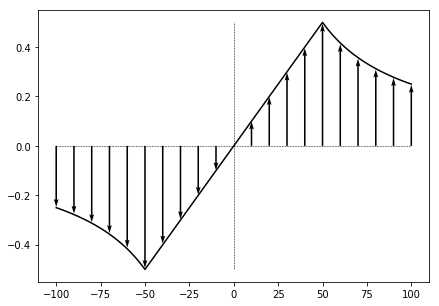

In [4]:
# Space
r = np.arange(-100,101,1)
r2 = np.arange(-100,110,10)
# Simulation
mv = inversions.Rankine(r,par)
mv2 = inversions.Rankine(r2,par)
# Figure
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
# Plot
ax.plot(r,mv,'k-')
ax.plot([-100,100],[0,0],'k--',linewidth=0.5)
ax.plot([0,0],[-0.5,0.5],'k--',linewidth=0.5)
Q = ax.quiver(r2,np.zeros(len(r2)),np.zeros(len(r2)),mv2,width=0.004,scale=1.6)
#ax.quiverkey(Q,0.8,0.1,0.5,label= '0.5 m/s')
plt.show()

### 2D representation of a Rankine vortex

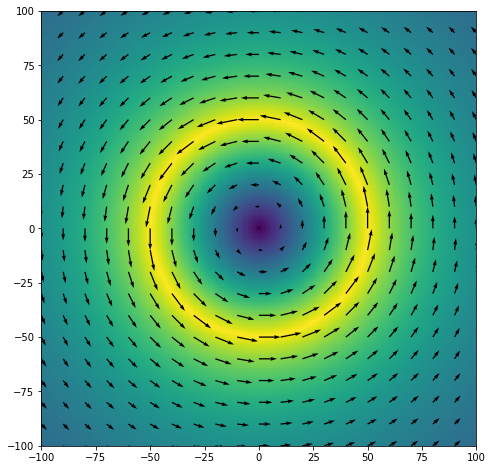

In [5]:
# Fine space
xx = np.arange(-100,101,1)
yy = np.arange(-100,101,1)
XX,YY = np.meshgrid(xx,yy)
# Coarse space
xx2 = np.arange(-100,110,10)
yy2 = np.arange(-100,110,10)
XX2,YY2 = np.meshgrid(xx2,yy2)
# Absolute velocities of fine space
angles,norms = inversions.SimulateRankine(center,par,XX,YY,fmt='AN')
# U and V on coarse space
rrU,rrV = inversions.SimulateRankine(center,par,XX2,YY2,fmt='UV')
# Figure setup
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_aspect('equal')
ax.set_ylim(-100,100)
ax.set_xlim(-100,100)
# Plots
ax.pcolormesh(XX,YY,norms)
ax.quiver(xx2,yy2,rrU,rrV,width=0.003,pivot='tail',scale=10)

plt.show()

# ADCP data analysis for eddy center detection

In [123]:
# Data import
eddy = 'M10'
U = eddies[eddy]['U']
V = eddies[eddy]['V']
U_filt = eddies[eddy]['U reg filt']
V_filt = eddies[eddy]['V reg filt']
atd = eddies[eddy]['ATD']
depths = eddies[eddy]['depths']
lon = eddies[eddy]['longitudes']
lat = eddies[eddy]['latitudes']
deltat = 100

In [124]:
# Projection on mercator plane
m = Basemap(projection='merc',llcrnrlat = min(lat)-1,urcrnrlat = max(lat)+1,llcrnrlon=min(lon)-1,urcrnrlon=max(lon)+1)
x,y = m(lon,lat)

# Find the center

## Evaluate the solid body rotation component
Here, using a filter (accounting for all three dimensions of the problem), we evaluate the relevance of the solid body rotation assumption. Using an iterating algorithm, we map the correlation to SBR

In [125]:
faisceau,ZZ2,Rvals,Pvals=inversions.SolidBodyCorrelation(U_filt,V_filt,atd,depths,sizemax=200e3)
## Warning caused by nans but no computation errors

/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


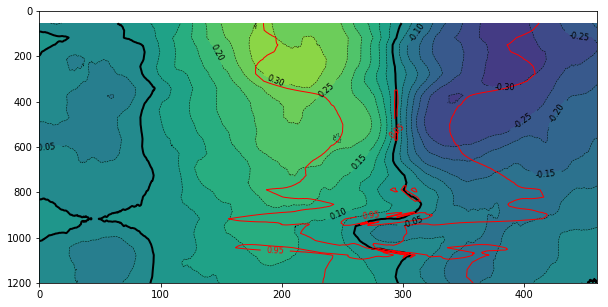

In [126]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(1200,0)
ax.set_xlim(min(atd)/1000,max(atd)/1000)
plottools.PlotADCP(ax,atd/1000,depths,V_filt)
levels = [0.95]
cont = ax.contour(faisceau/1000,ZZ2,Rvals,colors='r',linewidths=1,levels=levels)
ax.clabel(cont, fontsize=8, inline=1, fmt='%1.2f')
plt.show()

## Locate the center of the eddy

The strategy here is to simulate what the ship would have measured assuming it crossed a Rankine vortex centered in $(x_c,y_c)$. The distance between the simulation and measured data is minimized to obtain vortex center location and Rankine properties $(R,V)$.

In [127]:
def RankineErrorCenter(cpar,xm,ym,um,vm):
    xc,yc,R,V = cpar
    center = (xc,yc)
    par = (R,V)
    u,v = inversions.SimulateRankine(center,par,xm,ym)
    fntidx = np.isfinite(um)
    err = np.nansum(np.sqrt((um[fntidx] - u[fntidx])**2 + (vm[fntidx] - v[fntidx])**2))/np.sqrt(2*np.sum(fntidx))
    return(err)

A nice map of the error

In [68]:
xplore = np.arange(m.llcrnrx,m.urcrnrx,5e3)
yplore = np.arange(m.llcrnry,m.urcrnry,5e3)
Mrr = np.zeros((len(xplore),len(yplore)))
for i in range(len(xplore)):
    for j in range(len(yplore)):
        Mrr[i,j] = RankineErrorCenter([xplore[i],yplore[j],75e3,0.4],x,y,U_filt[:,5],V_filt[:,5])

/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


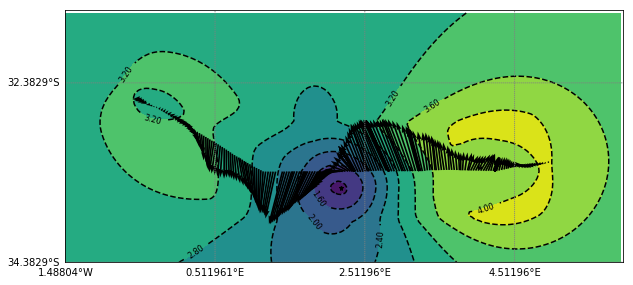

In [69]:
plt.figure(figsize=(10,5))
XX,YY = np.meshgrid(xplore,yplore)
M = np.transpose(Mrr)
plt.contourf(XX,YY,M)
cont = plt.contour(XX,YY,M,linestyles='dashed',colors='k')
ax.clabel(cont, fontsize=8, inline=1, fmt='%1.2f')
m.plot(XX[M==np.nanmin(M)],YY[M==np.nanmin(M)],'k*',ms=5)
m.quiver(x,y,U_filt[:,5],V_filt[:,5],pivot='tail',scale=5,width=0.003)
parallels = np.arange(m.llcrnrlat,m.urcrnrlat,2)
meridians = np.arange(m.llcrnrlon,m.urcrnrlon,2)
m.drawparallels(parallels,labels=[1,0,0,0],color='grey')
m.drawmeridians(meridians,labels=[0,0,0,1],color='grey')
plt.show()

In [128]:
Xvc = []
Yvc = []
deltat = 10
for i in range(len(depths)):
    vm = V_filt[:,i]
    if np.sum(np.isnan(vm)) == len(vm):
        xvc = np.nan
        yvc = np.nan
    else :
        index = analysis.VirtualCenter(vm)
        if index == False:
            xvc = np.nan
            yvc = np.nan
        else:
            xvc = x[index]
            yvc = y[index]
    Xvc.append(xvc)
    Yvc.append(yvc)
Xvc = np.array(Xvc)
Yvc = np.array(Yvc)

In [129]:
Xc = []
Yc = []
Er = []
S = []
Xc = np.full(len(depths),np.nan)
Yc = np.full(len(depths),np.nan)
rRs = np.full(len(depths),np.nan)
rVs = np.full(len(depths),np.nan)
Er = np.full(len(depths),np.nan)
S = np.full(len(depths),False)

for i in range(len(depths)):
    if np.isfinite(Xvc[i]):
        res = sciopt.minimize(fun = RankineErrorCenter,x0=(Xvc[i],Yvc[i],75e3,0.4),
                              args=(x,y,U_filt[:,i],V_filt[:,i]),method='Powell',tol=1e-10)
    else:
        res = {'x':[np.nan,np.nan,np.nan,np.nan],'fun':np.nan,'success':False}
    
    Xc[i] = res['x'][0]
    Yc[i] = res['x'][1]
    rRs[i] = res['x'][2]
    rVs[i] = res['x'][3]
    Er[i] = res['fun']
    S[i] = res['success']   

Simulate what we would have measured

In [130]:
rkV = np.full(V_filt.shape,np.nan)
rkU = np.full(U_filt.shape,np.nan)
for i in range(len(depths)):
    if np.isfinite(Xc[i]):
        rkU[:,i],rkV[:,i] = inversions.SimulateRankine((Xc[i],Yc[i]),(rRs[i],rVs[i]),x,y)

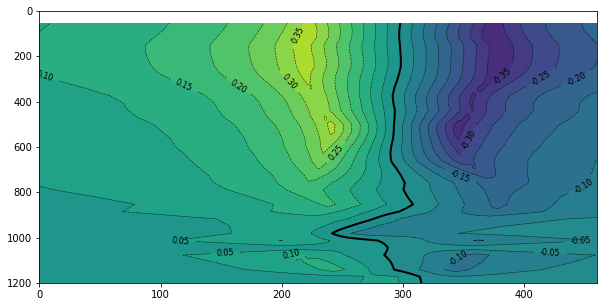

In [131]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
#X,Z = np.meshgrid(atd,depths)
ax.set_ylim(1200,0)
#ax.contourf(X,Z,np.transpose(rkV))
plottools.PlotADCP(ax,atd/1000,depths,rkV)

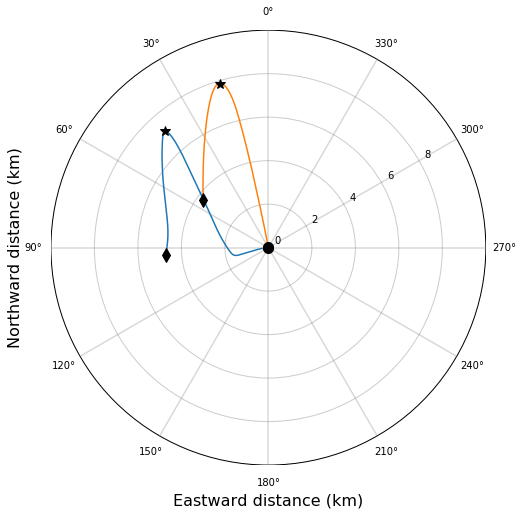

In [134]:
u = np.nanmean(U_filt[:,depths<350],axis=1)
v = np.nanmean(V_filt[:,depths<350],axis=1)
rku = np.nanmean(rkU[:,depths<350],axis=1)
rkv = np.nanmean(rkV[:,depths<350],axis=1)
deltat = 60
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
xlim = 10
plottools.Hodograph(ax,xlim,xtext=True,ytext=True)
plottools.PlotHodograph(ax,u,v,deltat,legend=False)
plottools.PlotHodograph(ax,rku,rkv,deltat,legend=False)

Hodograph of the position of the center

In [135]:
Xcint = np.zeros(len(depths))
Ycint = np.zeros(len(depths))
Xcint[1:] = np.nancumsum(Xc[1:] - Xc[:-1])
Ycint[1:] = np.nancumsum(Yc[1:] - Yc[:-1])

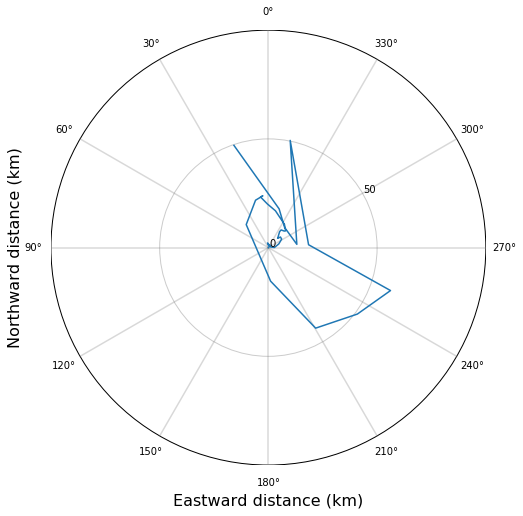

In [137]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
plottools.Hodograph(ax,100,grid=50,xtext=True,ytext=True)
ax.plot(Xcint[depths<1200]/1000,Ycint[depths<1200]/1000)
plt.show()

In [138]:
## Now project everything on the cylinder

In [139]:
Ur = np.zeros((len(x),len(depths)))
Vr = np.zeros((len(x),len(depths)))
R = np.zeros((len(x),len(depths)))
R2 = np.zeros((len(x),len(depths)))
for i in range(len(depths)):
    xc = Xc[i]
    yc = Yc[i]
    if np.isfinite(xc):
        v = V_filt[:,i]
        u = U_filt[:,i]
        r = np.sqrt((x-xc)**2 + (y - yc)**2)
        s = np.sign(x-xc)
        s[s == 0] = 1
        r2 = s*np.sqrt((x-xc)**2 + (y - yc)**2)
        angles = np.angle((x - xc) + (y - yc)*1j,deg=False)
        num = np.isfinite(u)
        for j in range(len(angles)):
            if num[j]:
                theta = angles[j]
                uri,vri = level2.Rotation([u[j]],[v[j]],theta,[0,0])
            else:
                uri = np.nan
                vri = np.nan
            Ur[j,i] = s[j]*uri
            Vr[j,i] = s[j]*vri
    else:
        Ur[:,i] = np.full(len(angles),np.nan)
        Vr[:,i] = np.full(len(angles),np.nan)
    R[:,i] = r
    R2[:,i] = r2

#omegas = 

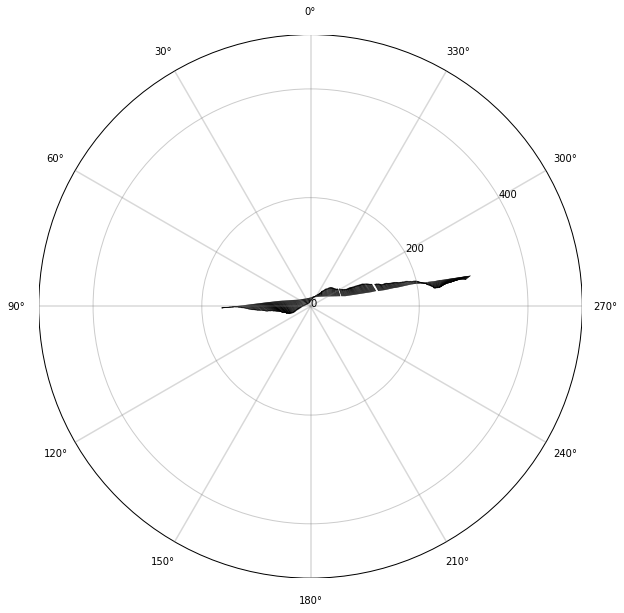

In [140]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
angles = np.angle((x - Xc[3]) + (y - Yc[3])*1j,deg=False)
plottools.Hodograph(ax,500,xtext=False,ytext=False,grid=200)
ax.quiver(R[:,5]/1000*np.cos(angles),R[:,5]/1000*np.sin(angles),U_filt[:,35],V_filt[:,35],scale=5,width=0.0005)
plt.show()

In [162]:
RR = np.arange(-150e3,250e3,1e3)
VR = np.full((len(RR),len(depths)),np.nan)

for i in range(len(depths[depths<700])):
    Vreg,Rreg = analysis.RegularLine(R2[:,i],Vr[:,i],5e3)
    Rreg = np.append(Rreg,0)
    Vreg = np.append(Vreg,0)
    if np.sum(np.isfinite(Vreg))/len(Vreg) > 0.8:
        f = sc.interpolate.interp1d(Rreg[np.isfinite(Vreg)],Vreg[np.isfinite(Vreg)],assume_sorted=False,kind='slinear')
        VR[:,i] = f(RR)
    else:
        VR[:,i] = np.full(len(RR),np.nan)


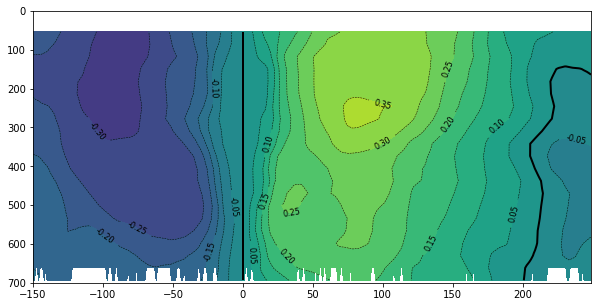

In [163]:
X,Z = np.meshgrid(RR,depths[depths<700])
#plt.ylim(700,0)
#plt.contourf(X,Z,np.transpose(VR))
#plt.contour(X,Z,np.transpose(VR),levels=[0],colors='k')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(700,0)
levels = np.round(np.arange(-0.6,0.65,.05),2)
levels2 = np.delete(levels,np.where(levels==0))
plottools.PlotADCP(ax,RR/1000,depths,VR,levels=levels,levels2=levels2)

In [44]:
Zet = (1/RR[1:])*((VR[1:,5] - VR[:-1,5])/(RR[1:] - RR[:-1]))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [93]:
def RadialVorticity(V,R,dr,depths):
    """
    R should be regular as hell
    """
    nR = R[1:-1] + dr/2
    Zeta = np.zeros((len(nR),len(depths)))
    for i in range(len(depths)):
        if np.sum(np.isfinite(V[:,i]))/len(V[:,i]) > 0.5:
            dVi = V[2:,i] - V[:-2,i]
            Zeta[:,i] = dVi/(dr)
        else:
            Zeta[:,i] = np.nan
    return(Zeta,nR)

In [167]:
Zeta = 2 * np.gradient(VR,1e3,axis=0)

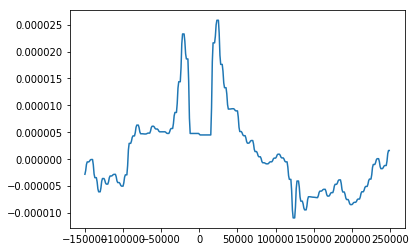

In [169]:
plt.plot(RR,Zeta[:,5])

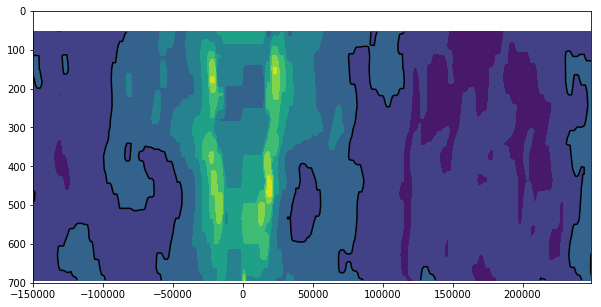

In [168]:
X,Z = np.meshgrid(RR,depths)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(700,0)
ax.contourf(X,Z,np.transpose(Zeta))
ax.contour(X,Z,np.transpose(Zeta),levels=[0],colors='k')

Knowing where the center is, we are able to compute the relative vorticity in a circulary symmetric system:
$$
    \zeta = \frac{1}{r} \frac{\partial_r V}{\partial r}
$$
Where $r$ is the radius, $V$ the tangential velocity defined positive counter-clockwise.

In [97]:
xx = np.arange(0,10,1)
yy = x**2

In [ ]:
yy.d